In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=5 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 26287 
    Total predicted counts          : 26549.33
    Total off counts                : 101830.00

    Total background counts         : 20366.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 31.4 s, sys: 252 ms, total: 31.6 s
Wall time: 39.9 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 26536 
    Total predicted counts          : 26596.33
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 26375 
    Total predicted counts          : 26517.73
    Total off counts                : 101672.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_15 

    Total counts                    : 26414 
    Total predicted counts          : 26492.73
    Total off counts                : 101547.00

    Total background counts         : 20309.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_16 

    Total counts                    : 26282 
    Total predicted counts          : 26568.93
    Total off counts                : 101928.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_29 

    Total counts                    : 26537 
    Total predicted counts          : 26515.13
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_30 

    Total counts                    : 26384 
    Total predicted counts          : 26514.13
    Total off counts                : 101654.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_48 

    Total counts                    : 26485 
    Total predicted counts          : 26521.13
    Total off counts                : 101689.00

    Total background counts         : 20337.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_49 

    Total counts                    : 26900 
    Total predicted counts          : 26518.53
    Total off counts                : 101676.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_60 

    Total counts                    : 26374 
    Total predicted counts          : 26449.73
    Total off counts                : 101332.00

    Total background counts         : 20266.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_61 

    Total counts                    : 26753 
    Total predicted counts          : 26619.33
    Total off counts                : 102180.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_71 

    Total counts                    : 26538 
    Total predicted counts          : 26522.33
    Total off counts                : 101695.00

    Total background counts         : 20339.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_72 

    Total counts                    : 26382 
    Total predicted counts          : 26378.73
    Total off counts                : 100977.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_88 

    Total counts                    : 26725 
    Total predicted counts          : 26549.33
    Total off counts                : 101830.00

    Total background counts         : 20366.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_89 

    Total counts                    : 26411 
    Total predicted counts          : 26455.13
    Total off counts                : 101359.00

    Total background counts         : 


SpectrumDatasetOnOff

    Name                            : obs_101 

    Total counts                    : 26348 
    Total predicted counts          : 26640.53
    Total off counts                : 102286.00

    Total background counts         : 20457.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_102 

    Total counts                    : 26539 
    Total predicted counts          : 26533.93
    Total off counts                : 101753.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_116 

    Total counts                    : 26520 
    Total predicted counts          : 26418.93
    Total off counts                : 101178.00

    Total background counts         : 20235.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_117 

    Total counts                    : 26107 
    Total predicted counts          : 26507.33
    Total off counts                : 101620.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_127 

    Total counts                    : 26277 
    Total predicted counts          : 26626.13
    Total off counts                : 102214.00

    Total background counts         : 20442.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_128 

    Total counts                    : 26435 
    Total predicted counts          : 26346.53
    Total off counts                : 100816.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_138 

    Total counts                    : 26842 
    Total predicted counts          : 26511.13
    Total off counts                : 101639.00

    Total background counts         : 20327.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_139 

    Total counts                    : 26417 
    Total predicted counts          : 26462.53
    Total off counts                : 101396.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_150 

    Total counts                    : 26623 
    Total predicted counts          : 26446.13
    Total off counts                : 101314.00

    Total background counts         : 20262.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_151 

    Total counts                    : 26838 
    Total predicted counts          : 26537.93
    Total off counts                : 101773.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_161 

    Total counts                    : 26626 
    Total predicted counts          : 26564.53
    Total off counts                : 101906.00

    Total background counts         : 20381.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_162 

    Total counts                    : 26420 
    Total predicted counts          : 26496.13
    Total off counts                : 101564.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_172 

    Total counts                    : 26446 
    Total predicted counts          : 26507.13
    Total off counts                : 101619.00

    Total background counts         : 20323.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_173 

    Total counts                    : 26439 
    Total predicted counts          : 26554.73
    Total off counts                : 101857.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_184 

    Total counts                    : 26596 
    Total predicted counts          : 26564.73
    Total off counts                : 101907.00

    Total background counts         : 20381.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_185 

    Total counts                    : 26527 
    Total predicted counts          : 26464.93
    Total off counts                : 101408.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_196 

    Total counts                    : 26440 
    Total predicted counts          : 26418.93
    Total off counts                : 101178.00

    Total background counts         : 20235.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_197 

    Total counts                    : 26608 
    Total predicted counts          : 26536.73
    Total off counts                : 101767.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_210 

    Total counts                    : 26457 
    Total predicted counts          : 26440.13
    Total off counts                : 101284.00

    Total background counts         : 20256.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_211 

    Total counts                    : 26649 
    Total predicted counts          : 26462.93
    Total off counts                : 101398.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_225 

    Total counts                    : 26370 
    Total predicted counts          : 26484.73
    Total off counts                : 101507.00

    Total background counts         : 20301.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_226 

    Total counts                    : 26564 
    Total predicted counts          : 26340.33
    Total off counts                : 100785.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_243 

    Total counts                    : 26582 
    Total predicted counts          : 26481.73
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_244 

    Total counts                    : 26303 
    Total predicted counts          : 26531.53
    Total off counts                : 101741.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_263 

    Total counts                    : 26511 
    Total predicted counts          : 26428.53
    Total off counts                : 101226.00

    Total background counts         : 20245.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_264 

    Total counts                    : 26507 
    Total predicted counts          : 26451.73
    Total off counts                : 101342.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_278 

    Total counts                    : 26462 
    Total predicted counts          : 26479.93
    Total off counts                : 101483.00

    Total background counts         : 20296.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_279 

    Total counts                    : 26601 
    Total predicted counts          : 26615.73
    Total off counts                : 102162.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_294 

    Total counts                    : 26816 
    Total predicted counts          : 26471.73
    Total off counts                : 101442.00

    Total background counts         : 20288.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_295 

    Total counts                    : 26499 
    Total predicted counts          : 26515.33
    Total off counts                : 101660.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_306 

    Total counts                    : 26275 
    Total predicted counts          : 26441.73
    Total off counts                : 101292.00

    Total background counts         : 20258.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_307 

    Total counts                    : 26474 
    Total predicted counts          : 26594.73
    Total off counts                : 102057.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_322 

    Total counts                    : 26560 
    Total predicted counts          : 26404.73
    Total off counts                : 101107.00

    Total background counts         : 20221.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_323 

    Total counts                    : 26726 
    Total predicted counts          : 26405.13
    Total off counts                : 101109.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_337 

    Total counts                    : 26610 
    Total predicted counts          : 26540.73
    Total off counts                : 101787.00

    Total background counts         : 20357.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_338 

    Total counts                    : 26469 
    Total predicted counts          : 26543.33
    Total off counts                : 101800.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_353 

    Total counts                    : 26457 
    Total predicted counts          : 26495.33
    Total off counts                : 101560.00

    Total background counts         : 20312.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_354 

    Total counts                    : 26424 
    Total predicted counts          : 26502.73
    Total off counts                : 101597.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_367 

    Total counts                    : 26057 
    Total predicted counts          : 26462.73
    Total off counts                : 101397.00

    Total background counts         : 20279.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_368 

    Total counts                    : 26606 
    Total predicted counts          : 26502.93
    Total off counts                : 101598.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_381 

    Total counts                    : 26565 
    Total predicted counts          : 26601.33
    Total off counts                : 102090.00

    Total background counts         : 20418.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_382 

    Total counts                    : 26442 
    Total predicted counts          : 26482.33
    Total off counts                : 101495.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_392 

    Total counts                    : 26204 
    Total predicted counts          : 26418.93
    Total off counts                : 101178.00

    Total background counts         : 20235.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_393 

    Total counts                    : 26225 
    Total predicted counts          : 26403.93
    Total off counts                : 101103.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 26336 
    Total predicted counts          : 26439.93
    Total off counts                : 101283.00

    Total background counts         : 20256.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_410 

    Total counts                    : 26502 
    Total predicted counts          : 26387.53
    Total off counts                : 101021.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_420 

    Total counts                    : 26197 
    Total predicted counts          : 26450.13
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_421 

    Total counts                    : 26480 
    Total predicted counts          : 26557.13
    Total off counts                : 101869.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_431 

    Total counts                    : 26369 
    Total predicted counts          : 26521.33
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_432 

    Total counts                    : 26612 
    Total predicted counts          : 26589.73
    Total off counts                : 102032.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_443 

    Total counts                    : 26557 
    Total predicted counts          : 26377.93
    Total off counts                : 100973.00

    Total background counts         : 20194.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_444 

    Total counts                    : 26573 
    Total predicted counts          : 26445.93
    Total off counts                : 101313.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_460 

    Total counts                    : 26442 
    Total predicted counts          : 26559.13
    Total off counts                : 101879.00

    Total background counts         : 20375.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_461 

    Total counts                    : 26490 
    Total predicted counts          : 26523.33
    Total off counts                : 101700.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_474 

    Total counts                    : 26350 
    Total predicted counts          : 26558.13
    Total off counts                : 101874.00

    Total background counts         : 20374.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_475 

    Total counts                    : 26496 
    Total predicted counts          : 26429.73
    Total off counts                : 101232.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_485 

    Total counts                    : 26863 
    Total predicted counts          : 26594.93
    Total off counts                : 102058.00

    Total background counts         : 20411.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_486 

    Total counts                    : 26485 
    Total predicted counts          : 26508.53
    Total off counts                : 101626.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_496 

    Total counts                    : 26466 
    Total predicted counts          : 26485.93
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 26601 
    Total predicted counts          : 26387.13
    Total off counts                : 101019.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_507 

    Total counts                    : 26474 
    Total predicted counts          : 26433.93
    Total off counts                : 101253.00

    Total background counts         : 20250.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_508 

    Total counts                    : 26614 
    Total predicted counts          : 26516.53
    Total off counts                : 101666.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_521 

    Total counts                    : 26513 
    Total predicted counts          : 26578.13
    Total off counts                : 101974.00

    Total background counts         : 20394.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_522 

    Total counts                    : 26502 
    Total predicted counts          : 26554.13
    Total off counts                : 101854.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_534 

    Total counts                    : 26545 
    Total predicted counts          : 26566.93
    Total off counts                : 101918.00

    Total background counts         : 20383.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_535 

    Total counts                    : 26517 
    Total predicted counts          : 26459.33
    Total off counts                : 101380.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_546 

    Total counts                    : 26170 
    Total predicted counts          : 26508.33
    Total off counts                : 101625.00

    Total background counts         : 20325.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_547 

    Total counts                    : 26451 
    Total predicted counts          : 26505.93
    Total off counts                : 101613.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_558 

    Total counts                    : 26353 
    Total predicted counts          : 26529.93
    Total off counts                : 101733.00

    Total background counts         : 20346.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_559 

    Total counts                    : 26700 
    Total predicted counts          : 26642.13
    Total off counts                : 102294.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_569 

    Total counts                    : 26592 
    Total predicted counts          : 26508.73
    Total off counts                : 101627.00

    Total background counts         : 20325.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_570 

    Total counts                    : 26548 
    Total predicted counts          : 26534.33
    Total off counts                : 101755.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_580 

    Total counts                    : 26408 
    Total predicted counts          : 26596.93
    Total off counts                : 102068.00

    Total background counts         : 20413.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_581 

    Total counts                    : 26492 
    Total predicted counts          : 26488.13
    Total off counts                : 101524.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_596 

    Total counts                    : 26308 
    Total predicted counts          : 26426.73
    Total off counts                : 101217.00

    Total background counts         : 20243.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_597 

    Total counts                    : 26582 
    Total predicted counts          : 26547.13
    Total off counts                : 101819.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_615 

    Total counts                    : 26443 
    Total predicted counts          : 26547.73
    Total off counts                : 101822.00

    Total background counts         : 20364.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_616 

    Total counts                    : 26591 
    Total predicted counts          : 26333.73
    Total off counts                : 100752.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_631 

    Total counts                    : 26494 
    Total predicted counts          : 26565.73
    Total off counts                : 101912.00

    Total background counts         : 20382.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_632 

    Total counts                    : 26534 
    Total predicted counts          : 26440.13
    Total off counts                : 101284.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_645 

    Total counts                    : 26655 
    Total predicted counts          : 26523.13
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_646 

    Total counts                    : 26311 
    Total predicted counts          : 26467.93
    Total off counts                : 101423.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_656 

    Total counts                    : 26350 
    Total predicted counts          : 26504.73
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_657 

    Total counts                    : 26289 
    Total predicted counts          : 26509.73
    Total off counts                : 101632.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_667 

    Total counts                    : 26692 
    Total predicted counts          : 26544.93
    Total off counts                : 101808.00

    Total background counts         : 20361.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_668 

    Total counts                    : 26540 
    Total predicted counts          : 26489.13
    Total off counts                : 101529.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_684 

    Total counts                    : 26574 
    Total predicted counts          : 26603.13
    Total off counts                : 102099.00

    Total background counts         : 20419.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_685 

    Total counts                    : 26512 
    Total predicted counts          : 26496.13
    Total off counts                : 101564.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_700 

    Total counts                    : 26434 
    Total predicted counts          : 26643.93
    Total off counts                : 102303.00

    Total background counts         : 20460.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_701 

    Total counts                    : 26767 
    Total predicted counts          : 26411.93
    Total off counts                : 101143.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_711 

    Total counts                    : 26535 
    Total predicted counts          : 26527.53
    Total off counts                : 101721.00

    Total background counts         : 20344.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_712 

    Total counts                    : 26600 
    Total predicted counts          : 26425.33
    Total off counts                : 101210.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_722 

    Total counts                    : 26308 
    Total predicted counts          : 26522.53
    Total off counts                : 101696.00

    Total background counts         : 20339.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_723 

    Total counts                    : 26375 
    Total predicted counts          : 26368.53
    Total off counts                : 100926.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_738 

    Total counts                    : 26414 
    Total predicted counts          : 26494.13
    Total off counts                : 101554.00

    Total background counts         : 20310.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_739 

    Total counts                    : 26597 
    Total predicted counts          : 26500.73
    Total off counts                : 101587.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_752 

    Total counts                    : 26329 
    Total predicted counts          : 26469.93
    Total off counts                : 101433.00

    Total background counts         : 20286.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_753 

    Total counts                    : 26553 
    Total predicted counts          : 26454.73
    Total off counts                : 101357.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_767 

    Total counts                    : 26164 
    Total predicted counts          : 26485.33
    Total off counts                : 101510.00

    Total background counts         : 20302.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_768 

    Total counts                    : 26450 
    Total predicted counts          : 26454.93
    Total off counts                : 101358.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_778 

    Total counts                    : 26534 
    Total predicted counts          : 26504.53
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_779 

    Total counts                    : 26652 
    Total predicted counts          : 26508.93
    Total off counts                : 101628.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_791 

    Total counts                    : 26523 
    Total predicted counts          : 26475.93
    Total off counts                : 101463.00

    Total background counts         : 20292.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_792 

    Total counts                    : 26659 
    Total predicted counts          : 26407.93
    Total off counts                : 101123.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_806 

    Total counts                    : 26459 
    Total predicted counts          : 26503.93
    Total off counts                : 101603.00

    Total background counts         : 20320.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_807 

    Total counts                    : 26315 
    Total predicted counts          : 26508.33
    Total off counts                : 101625.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_817 

    Total counts                    : 26523 
    Total predicted counts          : 26484.13
    Total off counts                : 101504.00

    Total background counts         : 20300.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_818 

    Total counts                    : 26518 
    Total predicted counts          : 26565.93
    Total off counts                : 101913.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_833 

    Total counts                    : 26669 
    Total predicted counts          : 26473.53
    Total off counts                : 101451.00

    Total background counts         : 20290.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_834 

    Total counts                    : 26554 
    Total predicted counts          : 26377.53
    Total off counts                : 100971.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_844 

    Total counts                    : 26433 
    Total predicted counts          : 26406.93
    Total off counts                : 101118.00

    Total background counts         : 20223.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_845 

    Total counts                    : 26311 
    Total predicted counts          : 26465.13
    Total off counts                : 101409.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_858 

    Total counts                    : 26455 
    Total predicted counts          : 26595.33
    Total off counts                : 102060.00

    Total background counts         : 20412.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_859 

    Total counts                    : 26320 
    Total predicted counts          : 26457.13
    Total off counts                : 101369.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_869 

    Total counts                    : 26369 
    Total predicted counts          : 26386.33
    Total off counts                : 101015.00

    Total background counts         : 20203.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_870 

    Total counts                    : 26274 
    Total predicted counts          : 26571.13
    Total off counts                : 101939.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_883 

    Total counts                    : 26588 
    Total predicted counts          : 26413.53
    Total off counts                : 101151.00

    Total background counts         : 20230.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_884 

    Total counts                    : 26430 
    Total predicted counts          : 26455.93
    Total off counts                : 101363.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_894 

    Total counts                    : 26641 
    Total predicted counts          : 26504.73
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_895 

    Total counts                    : 26706 
    Total predicted counts          : 26493.93
    Total off counts                : 101553.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_905 

    Total counts                    : 26385 
    Total predicted counts          : 26564.53
    Total off counts                : 101906.00

    Total background counts         : 20381.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_906 

    Total counts                    : 26787 
    Total predicted counts          : 26510.53
    Total off counts                : 101636.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_917 

    Total counts                    : 26657 
    Total predicted counts          : 26411.33
    Total off counts                : 101140.00

    Total background counts         : 20228.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_918 

    Total counts                    : 26534 
    Total predicted counts          : 26391.33
    Total off counts                : 101040.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_929 

    Total counts                    : 26431 
    Total predicted counts          : 26467.93
    Total off counts                : 101423.00

    Total background counts         : 20284.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_930 

    Total counts                    : 26701 
    Total predicted counts          : 26643.73
    Total off counts                : 102302.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_942 

    Total counts                    : 26181 
    Total predicted counts          : 26501.93
    Total off counts                : 101593.00

    Total background counts         : 20318.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_943 

    Total counts                    : 26798 
    Total predicted counts          : 26417.33
    Total off counts                : 101170.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_953 

    Total counts                    : 26494 
    Total predicted counts          : 26605.13
    Total off counts                : 102109.00

    Total background counts         : 20421.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_954 

    Total counts                    : 26423 
    Total predicted counts          : 26425.13
    Total off counts                : 101209.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_975 

    Total counts                    : 26487 
    Total predicted counts          : 26485.93
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_976 

    Total counts                    : 26627 
    Total predicted counts          : 26472.13
    Total off counts                : 101444.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_987 

    Total counts                    : 26669 
    Total predicted counts          : 26401.53
    Total off counts                : 101091.00

    Total background counts         : 20218.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_988 

    Total counts                    : 26668 
    Total predicted counts          : 26499.73
    Total off counts                : 101582.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_998 

    Total counts                    : 26471 
    Total predicted counts          : 26517.73
    Total off counts                : 101672.00

    Total background counts         : 20334.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_999 

    Total counts                    : 26617 
    Total predicted counts          : 26443.73
    Total off counts                : 101302.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_1013 

    Total counts                    : 26318 
    Total predicted counts          : 26533.73
    Total off counts                : 101752.00

    Total background counts         : 20350.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1014 

    Total counts                    : 26568 
    Total predicted counts          : 26530.13
    Total off counts                : 101734.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1027 

    Total counts                    : 26696 
    Total predicted counts          : 26625.13
    Total off counts                : 102209.00

    Total background counts         : 20441.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1028 

    Total counts                    : 26330 
    Total predicted counts          : 26565.93
    Total off counts                : 101913.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1038 

    Total counts                    : 26745 
    Total predicted counts          : 26563.73
    Total off counts                : 101902.00

    Total background counts         : 20380.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1039 

    Total counts                    : 26576 
    Total predicted counts          : 26439.53
    Total off counts                : 101281.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1051 

    Total counts                    : 26475 
    Total predicted counts          : 26624.93
    Total off counts                : 102208.00

    Total background counts         : 20441.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1052 

    Total counts                    : 26689 
    Total predicted counts          : 26503.33
    Total off counts                : 101600.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1068 

    Total counts                    : 26597 
    Total predicted counts          : 26413.53
    Total off counts                : 101151.00

    Total background counts         : 20230.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1069 

    Total counts                    : 26424 
    Total predicted counts          : 26552.53
    Total off counts                : 101846.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1085 

    Total counts                    : 26450 
    Total predicted counts          : 26457.53
    Total off counts                : 101371.00

    Total background counts         : 20274.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1086 

    Total counts                    : 26877 
    Total predicted counts          : 26507.73
    Total off counts                : 101622.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1096 

    Total counts                    : 26490 
    Total predicted counts          : 26535.13
    Total off counts                : 101759.00

    Total background counts         : 20351.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1097 

    Total counts                    : 26715 
    Total predicted counts          : 26514.93
    Total off counts                : 101658.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1108 

    Total counts                    : 26489 
    Total predicted counts          : 26609.93
    Total off counts                : 102133.00

    Total background counts         : 20426.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1109 

    Total counts                    : 26424 
    Total predicted counts          : 26597.13
    Total off counts                : 102069.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1127 

    Total counts                    : 26574 
    Total predicted counts          : 26439.73
    Total off counts                : 101282.00

    Total background counts         : 20256.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1128 

    Total counts                    : 26545 
    Total predicted counts          : 26610.93
    Total off counts                : 102138.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1141 

    Total counts                    : 26561 
    Total predicted counts          : 26452.13
    Total off counts                : 101344.00

    Total background counts         : 20268.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1142 

    Total counts                    : 26660 
    Total predicted counts          : 26562.53
    Total off counts                : 101896.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1157 

    Total counts                    : 26722 
    Total predicted counts          : 26521.33
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1158 

    Total counts                    : 26560 
    Total predicted counts          : 26442.53
    Total off counts                : 101296.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1176 

    Total counts                    : 26339 
    Total predicted counts          : 26535.93
    Total off counts                : 101763.00

    Total background counts         : 20352.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1177 

    Total counts                    : 26564 
    Total predicted counts          : 26567.33
    Total off counts                : 101920.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1196 

    Total counts                    : 26587 
    Total predicted counts          : 26427.33
    Total off counts                : 101220.00

    Total background counts         : 20244.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1197 

    Total counts                    : 26719 
    Total predicted counts          : 26572.33
    Total off counts                : 101945.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1210 

    Total counts                    : 26549 
    Total predicted counts          : 26494.13
    Total off counts                : 101554.00

    Total background counts         : 20310.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1211 

    Total counts                    : 26504 
    Total predicted counts          : 26449.73
    Total off counts                : 101332.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1223 

    Total counts                    : 26511 
    Total predicted counts          : 26543.73
    Total off counts                : 101802.00

    Total background counts         : 20360.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1224 

    Total counts                    : 26267 
    Total predicted counts          : 26521.73
    Total off counts                : 101692.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1237 

    Total counts                    : 26694 
    Total predicted counts          : 26547.13
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1238 

    Total counts                    : 26438 
    Total predicted counts          : 26413.73
    Total off counts                : 101152.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1251 

    Total counts                    : 26208 
    Total predicted counts          : 26446.73
    Total off counts                : 101317.00

    Total background counts         : 20263.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1252 

    Total counts                    : 26704 
    Total predicted counts          : 26518.53
    Total off counts                : 101676.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1263 

    Total counts                    : 26711 
    Total predicted counts          : 26453.13
    Total off counts                : 101349.00

    Total background counts         : 20269.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1264 

    Total counts                    : 26547 
    Total predicted counts          : 26537.93
    Total off counts                : 101773.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1282 

    Total counts                    : 26418 
    Total predicted counts          : 26416.33
    Total off counts                : 101165.00

    Total background counts         : 20233.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1283 

    Total counts                    : 26516 
    Total predicted counts          : 26411.53
    Total off counts                : 101141.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1295 

    Total counts                    : 26530 
    Total predicted counts          : 26523.53
    Total off counts                : 101701.00

    Total background counts         : 20340.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1296 

    Total counts                    : 26546 
    Total predicted counts          : 26543.33
    Total off counts                : 101800.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1306 

    Total counts                    : 26398 
    Total predicted counts          : 26413.13
    Total off counts                : 101149.00

    Total background counts         : 20229.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1307 

    Total counts                    : 26178 
    Total predicted counts          : 26504.13
    Total off counts                : 101604.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1326 

    Total counts                    : 26933 
    Total predicted counts          : 26488.73
    Total off counts                : 101527.00

    Total background counts         : 20305.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1327 

    Total counts                    : 26069 
    Total predicted counts          : 26477.73
    Total off counts                : 101472.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1347 

    Total counts                    : 26283 
    Total predicted counts          : 26515.13
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1348 

    Total counts                    : 26486 
    Total predicted counts          : 26519.53
    Total off counts                : 101681.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1364 

    Total counts                    : 26091 
    Total predicted counts          : 26438.13
    Total off counts                : 101274.00

    Total background counts         : 20254.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1365 

    Total counts                    : 26669 
    Total predicted counts          : 26507.33
    Total off counts                : 101620.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1383 

    Total counts                    : 26401 
    Total predicted counts          : 26452.33
    Total off counts                : 101345.00

    Total background counts         : 20269.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1384 

    Total counts                    : 26593 
    Total predicted counts          : 26563.73
    Total off counts                : 101902.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1395 

    Total counts                    : 26587 
    Total predicted counts          : 26523.53
    Total off counts                : 101701.00

    Total background counts         : 20340.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1396 

    Total counts                    : 26305 
    Total predicted counts          : 26556.13
    Total off counts                : 101864.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1410 

    Total counts                    : 26453 
    Total predicted counts          : 26497.73
    Total off counts                : 101572.00

    Total background counts         : 20314.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1411 

    Total counts                    : 26419 
    Total predicted counts          : 26428.13
    Total off counts                : 101224.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1424 

    Total counts                    : 26646 
    Total predicted counts          : 26462.73
    Total off counts                : 101397.00

    Total background counts         : 20279.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1425 

    Total counts                    : 26637 
    Total predicted counts          : 26514.53
    Total off counts                : 101656.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1443 

    Total counts                    : 26502 
    Total predicted counts          : 26519.73
    Total off counts                : 101682.00

    Total background counts         : 20336.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1444 

    Total counts                    : 26314 
    Total predicted counts          : 26381.53
    Total off counts                : 100991.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1455 

    Total counts                    : 26479 
    Total predicted counts          : 26573.13
    Total off counts                : 101949.00

    Total background counts         : 20389.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1456 

    Total counts                    : 26547 
    Total predicted counts          : 26457.13
    Total off counts                : 101369.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1473 

    Total counts                    : 26537 
    Total predicted counts          : 26481.73
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1474 

    Total counts                    : 26581 
    Total predicted counts          : 26532.73
    Total off counts                : 101747.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1484 

    Total counts                    : 26457 
    Total predicted counts          : 26490.33
    Total off counts                : 101535.00

    Total background counts         : 20307.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1485 

    Total counts                    : 26453 
    Total predicted counts          : 26579.93
    Total off counts                : 101983.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1504 

    Total counts                    : 26682 
    Total predicted counts          : 26647.93
    Total off counts                : 102323.00

    Total background counts         : 20464.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1505 

    Total counts                    : 26485 
    Total predicted counts          : 26445.13
    Total off counts                : 101309.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1517 

    Total counts                    : 26817 
    Total predicted counts          : 26541.33
    Total off counts                : 101790.00

    Total background counts         : 20358.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1518 

    Total counts                    : 26659 
    Total predicted counts          : 26533.73
    Total off counts                : 101752.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1529 

    Total counts                    : 26270 
    Total predicted counts          : 26575.53
    Total off counts                : 101961.00

    Total background counts         : 20392.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1530 

    Total counts                    : 26264 
    Total predicted counts          : 26441.93
    Total off counts                : 101293.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1546 

    Total counts                    : 26394 
    Total predicted counts          : 26473.13
    Total off counts                : 101449.00

    Total background counts         : 20289.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1547 

    Total counts                    : 26425 
    Total predicted counts          : 26455.73
    Total off counts                : 101362.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1563 

    Total counts                    : 26518 
    Total predicted counts          : 26538.73
    Total off counts                : 101777.00

    Total background counts         : 20355.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1564 

    Total counts                    : 26441 
    Total predicted counts          : 26500.73
    Total off counts                : 101587.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1578 

    Total counts                    : 26308 
    Total predicted counts          : 26613.93
    Total off counts                : 102153.00

    Total background counts         : 20430.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1579 

    Total counts                    : 26474 
    Total predicted counts          : 26417.73
    Total off counts                : 101172.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1591 

    Total counts                    : 26550 
    Total predicted counts          : 26490.33
    Total off counts                : 101535.00

    Total background counts         : 20307.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1592 

    Total counts                    : 26472 
    Total predicted counts          : 26335.73
    Total off counts                : 100762.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1604 

    Total counts                    : 26290 
    Total predicted counts          : 26644.53
    Total off counts                : 102306.00

    Total background counts         : 20461.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1605 

    Total counts                    : 26823 
    Total predicted counts          : 26578.93
    Total off counts                : 101978.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1619 

    Total counts                    : 26474 
    Total predicted counts          : 26455.53
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1620 

    Total counts                    : 26613 
    Total predicted counts          : 26537.93
    Total off counts                : 101773.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1632 

    Total counts                    : 26293 
    Total predicted counts          : 26374.13
    Total off counts                : 100954.00

    Total background counts         : 20190.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1633 

    Total counts                    : 26222 
    Total predicted counts          : 26467.53
    Total off counts                : 101421.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1644 

    Total counts                    : 26265 
    Total predicted counts          : 26500.53
    Total off counts                : 101586.00

    Total background counts         : 20317.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1645 

    Total counts                    : 26435 
    Total predicted counts          : 26556.73
    Total off counts                : 101867.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1655 

    Total counts                    : 26756 
    Total predicted counts          : 26422.33
    Total off counts                : 101195.00

    Total background counts         : 20239.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1656 

    Total counts                    : 26379 
    Total predicted counts          : 26549.33
    Total off counts                : 101830.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1669 

    Total counts                    : 26613 
    Total predicted counts          : 26497.33
    Total off counts                : 101570.00

    Total background counts         : 20314.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1670 

    Total counts                    : 26529 
    Total predicted counts          : 26614.53
    Total off counts                : 102156.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1685 

    Total counts                    : 26494 
    Total predicted counts          : 26613.53
    Total off counts                : 102151.00

    Total background counts         : 20430.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1686 

    Total counts                    : 26826 
    Total predicted counts          : 26494.53
    Total off counts                : 101556.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1696 

    Total counts                    : 26596 
    Total predicted counts          : 26450.33
    Total off counts                : 101335.00

    Total background counts         : 20267.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1697 

    Total counts                    : 26755 
    Total predicted counts          : 26461.93
    Total off counts                : 101393.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1716 

    Total counts                    : 26865 
    Total predicted counts          : 26512.13
    Total off counts                : 101644.00

    Total background counts         : 20328.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1717 

    Total counts                    : 26307 
    Total predicted counts          : 26528.13
    Total off counts                : 101724.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1735 

    Total counts                    : 26416 
    Total predicted counts          : 26473.73
    Total off counts                : 101452.00

    Total background counts         : 20290.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1736 

    Total counts                    : 26307 
    Total predicted counts          : 26458.33
    Total off counts                : 101375.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1754 

    Total counts                    : 26327 
    Total predicted counts          : 26475.53
    Total off counts                : 101461.00

    Total background counts         : 20292.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1755 

    Total counts                    : 26278 
    Total predicted counts          : 26396.13
    Total off counts                : 101064.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1767 

    Total counts                    : 26511 
    Total predicted counts          : 26458.33
    Total off counts                : 101375.00

    Total background counts         : 20275.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1768 

    Total counts                    : 26474 
    Total predicted counts          : 26416.73
    Total off counts                : 101167.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1779 

    Total counts                    : 26543 
    Total predicted counts          : 26410.33
    Total off counts                : 101135.00

    Total background counts         : 20227.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1780 

    Total counts                    : 26498 
    Total predicted counts          : 26426.53
    Total off counts                : 101216.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1792 

    Total counts                    : 26755 
    Total predicted counts          : 26390.53
    Total off counts                : 101036.00

    Total background counts         : 20207.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1793 

    Total counts                    : 26577 
    Total predicted counts          : 26571.33
    Total off counts                : 101940.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1803 

    Total counts                    : 26687 
    Total predicted counts          : 26434.73
    Total off counts                : 101257.00

    Total background counts         : 20251.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1804 

    Total counts                    : 26450 
    Total predicted counts          : 26559.33
    Total off counts                : 101880.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1815 

    Total counts                    : 26707 
    Total predicted counts          : 26556.53
    Total off counts                : 101866.00

    Total background counts         : 20373.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1816 

    Total counts                    : 26353 
    Total predicted counts          : 26466.53
    Total off counts                : 101416.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1828 

    Total counts                    : 26404 
    Total predicted counts          : 26453.33
    Total off counts                : 101350.00

    Total background counts         : 20270.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1829 

    Total counts                    : 26605 
    Total predicted counts          : 26416.73
    Total off counts                : 101167.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1841 

    Total counts                    : 26489 
    Total predicted counts          : 26585.13
    Total off counts                : 102009.00

    Total background counts         : 20401.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1842 

    Total counts                    : 26529 
    Total predicted counts          : 26555.93
    Total off counts                : 101863.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1860 

    Total counts                    : 26270 
    Total predicted counts          : 26445.93
    Total off counts                : 101313.00

    Total background counts         : 20262.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1861 

    Total counts                    : 26495 
    Total predicted counts          : 26567.53
    Total off counts                : 101921.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1873 

    Total counts                    : 26345 
    Total predicted counts          : 26550.53
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1874 

    Total counts                    : 26861 
    Total predicted counts          : 26485.13
    Total off counts                : 101509.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1896 

    Total counts                    : 26509 
    Total predicted counts          : 26610.73
    Total off counts                : 102137.00

    Total background counts         : 20427.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1897 

    Total counts                    : 26536 
    Total predicted counts          : 26542.53
    Total off counts                : 101796.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1910 

    Total counts                    : 26473 
    Total predicted counts          : 26500.73
    Total off counts                : 101587.00

    Total background counts         : 20317.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1911 

    Total counts                    : 26760 
    Total predicted counts          : 26564.53
    Total off counts                : 101906.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1921 

    Total counts                    : 26474 
    Total predicted counts          : 26437.13
    Total off counts                : 101269.00

    Total background counts         : 20253.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1922 

    Total counts                    : 26396 
    Total predicted counts          : 26457.13
    Total off counts                : 101369.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1934 

    Total counts                    : 26515 
    Total predicted counts          : 26566.13
    Total off counts                : 101914.00

    Total background counts         : 20382.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1935 

    Total counts                    : 26585 
    Total predicted counts          : 26461.73
    Total off counts                : 101392.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1947 

    Total counts                    : 26456 
    Total predicted counts          : 26547.13
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1948 

    Total counts                    : 26321 
    Total predicted counts          : 26450.73
    Total off counts                : 101337.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1959 

    Total counts                    : 26309 
    Total predicted counts          : 26588.33
    Total off counts                : 102025.00

    Total background counts         : 20405.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1960 

    Total counts                    : 26421 
    Total predicted counts          : 26510.13
    Total off counts                : 101634.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1972 

    Total counts                    : 26186 
    Total predicted counts          : 26561.33
    Total off counts                : 101890.00

    Total background counts         : 20378.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1973 

    Total counts                    : 26449 
    Total predicted counts          : 26429.13
    Total off counts                : 101229.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1986 

    Total counts                    : 26548 
    Total predicted counts          : 26557.13
    Total off counts                : 101869.00

    Total background counts         : 20373.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1987 

    Total counts                    : 26500 
    Total predicted counts          : 26494.13
    Total off counts                : 101554.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2001 

    Total counts                    : 26382 
    Total predicted counts          : 26399.93
    Total off counts                : 101083.00

    Total background counts         : 20216.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2002 

    Total counts                    : 26656 
    Total predicted counts          : 26483.13
    Total off counts                : 101499.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2015 

    Total counts                    : 26524 
    Total predicted counts          : 26463.53
    Total off counts                : 101401.00

    Total background counts         : 20280.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2016 

    Total counts                    : 26702 
    Total predicted counts          : 26502.13
    Total off counts                : 101594.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2040 

    Total counts                    : 26606 
    Total predicted counts          : 26516.93
    Total off counts                : 101668.00

    Total background counts         : 20333.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2041 

    Total counts                    : 26299 
    Total predicted counts          : 26531.53
    Total off counts                : 101741.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2054 

    Total counts                    : 27010 
    Total predicted counts          : 26485.53
    Total off counts                : 101511.00

    Total background counts         : 20302.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2055 

    Total counts                    : 26560 
    Total predicted counts          : 26561.93
    Total off counts                : 101893.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2067 

    Total counts                    : 26386 
    Total predicted counts          : 26495.53
    Total off counts                : 101561.00

    Total background counts         : 20312.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2068 

    Total counts                    : 26537 
    Total predicted counts          : 26381.13
    Total off counts                : 100989.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2080 

    Total counts                    : 26106 
    Total predicted counts          : 26478.13
    Total off counts                : 101474.00

    Total background counts         : 20294.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2081 

    Total counts                    : 26635 
    Total predicted counts          : 26546.93
    Total off counts                : 101818.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2102 

    Total counts                    : 26708 
    Total predicted counts          : 26448.33
    Total off counts                : 101325.00

    Total background counts         : 20265.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2103 

    Total counts                    : 26429 
    Total predicted counts          : 26481.73
    Total off counts                : 101492.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2121 

    Total counts                    : 26494 
    Total predicted counts          : 26459.73
    Total off counts                : 101382.00

    Total background counts         : 20276.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2122 

    Total counts                    : 26479 
    Total predicted counts          : 26314.33
    Total off counts                : 100655.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2135 

    Total counts                    : 26398 
    Total predicted counts          : 26458.73
    Total off counts                : 101377.00

    Total background counts         : 20275.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2136 

    Total counts                    : 26677 
    Total predicted counts          : 26470.53
    Total off counts                : 101436.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2151 

    Total counts                    : 26440 
    Total predicted counts          : 26486.13
    Total off counts                : 101514.00

    Total background counts         : 20302.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2152 

    Total counts                    : 26516 
    Total predicted counts          : 26431.73
    Total off counts                : 101242.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2164 

    Total counts                    : 26498 
    Total predicted counts          : 26510.93
    Total off counts                : 101638.00

    Total background counts         : 20327.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2165 

    Total counts                    : 26464 
    Total predicted counts          : 26516.33
    Total off counts                : 101665.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2186 

    Total counts                    : 26373 
    Total predicted counts          : 26582.33
    Total off counts                : 101995.00

    Total background counts         : 20399.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2187 

    Total counts                    : 26506 
    Total predicted counts          : 26544.93
    Total off counts                : 101808.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2197 

    Total counts                    : 26728 
    Total predicted counts          : 26541.73
    Total off counts                : 101792.00

    Total background counts         : 20358.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2198 

    Total counts                    : 26492 
    Total predicted counts          : 26432.53
    Total off counts                : 101246.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2213 

    Total counts                    : 26374 
    Total predicted counts          : 26393.93
    Total off counts                : 101053.00

    Total background counts         : 20210.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2214 

    Total counts                    : 26511 
    Total predicted counts          : 26372.53
    Total off counts                : 100946.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2233 

    Total counts                    : 26741 
    Total predicted counts          : 26386.53
    Total off counts                : 101016.00

    Total background counts         : 20203.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2234 

    Total counts                    : 26275 
    Total predicted counts          : 26448.13
    Total off counts                : 101324.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2245 

    Total counts                    : 26359 
    Total predicted counts          : 26392.73
    Total off counts                : 101047.00

    Total background counts         : 20209.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2246 

    Total counts                    : 26502 
    Total predicted counts          : 26383.13
    Total off counts                : 100999.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2261 

    Total counts                    : 26737 
    Total predicted counts          : 26524.13
    Total off counts                : 101704.00

    Total background counts         : 20340.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2262 

    Total counts                    : 26508 
    Total predicted counts          : 26566.13
    Total off counts                : 101914.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2273 

    Total counts                    : 26527 
    Total predicted counts          : 26392.13
    Total off counts                : 101044.00

    Total background counts         : 20208.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2274 

    Total counts                    : 26766 
    Total predicted counts          : 26589.73
    Total off counts                : 102032.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2288 

    Total counts                    : 26404 
    Total predicted counts          : 26386.53
    Total off counts                : 101016.00

    Total background counts         : 20203.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2289 

    Total counts                    : 26836 
    Total predicted counts          : 26429.13
    Total off counts                : 101229.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2299 

    Total counts                    : 26386 
    Total predicted counts          : 26456.53
    Total off counts                : 101366.00

    Total background counts         : 20273.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2300 

    Total counts                    : 26562 
    Total predicted counts          : 26561.33
    Total off counts                : 101890.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2320 

    Total counts                    : 26621 
    Total predicted counts          : 26563.33
    Total off counts                : 101900.00

    Total background counts         : 20380.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2321 

    Total counts                    : 26492 
    Total predicted counts          : 26479.93
    Total off counts                : 101483.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2334 

    Total counts                    : 26536 
    Total predicted counts          : 26503.53
    Total off counts                : 101601.00

    Total background counts         : 20320.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2335 

    Total counts                    : 26441 
    Total predicted counts          : 26352.13
    Total off counts                : 100844.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2353 

    Total counts                    : 26435 
    Total predicted counts          : 26609.33
    Total off counts                : 102130.00

    Total background counts         : 20426.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2354 

    Total counts                    : 26602 
    Total predicted counts          : 26411.33
    Total off counts                : 101140.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2375 

    Total counts                    : 26490 
    Total predicted counts          : 26316.33
    Total off counts                : 100665.00

    Total background counts         : 20133.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2376 

    Total counts                    : 26759 
    Total predicted counts          : 26377.73
    Total off counts                : 100972.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2387 

    Total counts                    : 26449 
    Total predicted counts          : 26532.53
    Total off counts                : 101746.00

    Total background counts         : 20349.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2388 

    Total counts                    : 26368 
    Total predicted counts          : 26611.93
    Total off counts                : 102143.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2399 

    Total counts                    : 26414 
    Total predicted counts          : 26448.33
    Total off counts                : 101325.00

    Total background counts         : 20265.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2400 

    Total counts                    : 26433 
    Total predicted counts          : 26467.93
    Total off counts                : 101423.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2415 

    Total counts                    : 26455 
    Total predicted counts          : 26504.13
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2416 

    Total counts                    : 26375 
    Total predicted counts          : 26410.93
    Total off counts                : 101138.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2434 

    Total counts                    : 26585 
    Total predicted counts          : 26534.53
    Total off counts                : 101756.00

    Total background counts         : 20351.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2435 

    Total counts                    : 26640 
    Total predicted counts          : 26512.93
    Total off counts                : 101648.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2445 

    Total counts                    : 26735 
    Total predicted counts          : 26597.33
    Total off counts                : 102070.00

    Total background counts         : 20414.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2446 

    Total counts                    : 26308 
    Total predicted counts          : 26462.33
    Total off counts                : 101395.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2463 

    Total counts                    : 26560 
    Total predicted counts          : 26440.53
    Total off counts                : 101286.00

    Total background counts         : 20257.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2464 

    Total counts                    : 26503 
    Total predicted counts          : 26539.53
    Total off counts                : 101781.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2477 

    Total counts                    : 26422 
    Total predicted counts          : 26549.33
    Total off counts                : 101830.00

    Total background counts         : 20366.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2478 

    Total counts                    : 26554 
    Total predicted counts          : 26436.93
    Total off counts                : 101268.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2489 

    Total counts                    : 26613 
    Total predicted counts          : 26397.33
    Total off counts                : 101070.00

    Total background counts         : 20214.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2490 

    Total counts                    : 26381 
    Total predicted counts          : 26569.33
    Total off counts                : 101930.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2500 

    Total counts                    : 26446 
    Total predicted counts          : 26578.13
    Total off counts                : 101974.00

    Total background counts         : 20394.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2501 

    Total counts                    : 26353 
    Total predicted counts          : 26427.73
    Total off counts                : 101222.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2514 

    Total counts                    : 26637 
    Total predicted counts          : 26490.53
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2515 

    Total counts                    : 26554 
    Total predicted counts          : 26471.13
    Total off counts                : 101439.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2525 

    Total counts                    : 26392 
    Total predicted counts          : 26401.73
    Total off counts                : 101092.00

    Total background counts         : 20218.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2526 

    Total counts                    : 26161 
    Total predicted counts          : 26505.13
    Total off counts                : 101609.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2541 

    Total counts                    : 26464 
    Total predicted counts          : 26460.73
    Total off counts                : 101387.00

    Total background counts         : 20277.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2542 

    Total counts                    : 26583 
    Total predicted counts          : 26622.93
    Total off counts                : 102198.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2556 

    Total counts                    : 26306 
    Total predicted counts          : 26492.93
    Total off counts                : 101548.00

    Total background counts         : 20309.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2557 

    Total counts                    : 26306 
    Total predicted counts          : 26480.93
    Total off counts                : 101488.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2572 

    Total counts                    : 26603 
    Total predicted counts          : 26484.53
    Total off counts                : 101506.00

    Total background counts         : 20301.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2573 

    Total counts                    : 26515 
    Total predicted counts          : 26496.13
    Total off counts                : 101564.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2584 

    Total counts                    : 26672 
    Total predicted counts          : 26437.93
    Total off counts                : 101273.00

    Total background counts         : 20254.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2585 

    Total counts                    : 26493 
    Total predicted counts          : 26404.33
    Total off counts                : 101105.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2600 

    Total counts                    : 26124 
    Total predicted counts          : 26332.33
    Total off counts                : 100745.00

    Total background counts         : 20149.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2601 

    Total counts                    : 26625 
    Total predicted counts          : 26517.33
    Total off counts                : 101670.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2620 

    Total counts                    : 26647 
    Total predicted counts          : 26536.93
    Total off counts                : 101768.00

    Total background counts         : 20353.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2621 

    Total counts                    : 26468 
    Total predicted counts          : 26455.93
    Total off counts                : 101363.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2632 

    Total counts                    : 26741 
    Total predicted counts          : 26514.93
    Total off counts                : 101658.00

    Total background counts         : 20331.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2633 

    Total counts                    : 26292 
    Total predicted counts          : 26448.53
    Total off counts                : 101326.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2652 

    Total counts                    : 26578 
    Total predicted counts          : 26397.53
    Total off counts                : 101071.00

    Total background counts         : 20214.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2653 

    Total counts                    : 26710 
    Total predicted counts          : 26598.93
    Total off counts                : 102078.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2666 

    Total counts                    : 26470 
    Total predicted counts          : 26563.33
    Total off counts                : 101900.00

    Total background counts         : 20380.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2667 

    Total counts                    : 26562 
    Total predicted counts          : 26655.93
    Total off counts                : 102363.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2681 

    Total counts                    : 26624 
    Total predicted counts          : 26472.53
    Total off counts                : 101446.00

    Total background counts         : 20289.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2682 

    Total counts                    : 26365 
    Total predicted counts          : 26361.53
    Total off counts                : 100891.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2699 

    Total counts                    : 26449 
    Total predicted counts          : 26456.53
    Total off counts                : 101366.00

    Total background counts         : 20273.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2700 

    Total counts                    : 26655 
    Total predicted counts          : 26577.93
    Total off counts                : 101973.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2713 

    Total counts                    : 26456 
    Total predicted counts          : 26517.33
    Total off counts                : 101670.00

    Total background counts         : 20334.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2714 

    Total counts                    : 26401 
    Total predicted counts          : 26431.93
    Total off counts                : 101243.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2736 

    Total counts                    : 26724 
    Total predicted counts          : 26544.13
    Total off counts                : 101804.00

    Total background counts         : 20360.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2737 

    Total counts                    : 26228 
    Total predicted counts          : 26408.93
    Total off counts                : 101128.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2748 

    Total counts                    : 26586 
    Total predicted counts          : 26472.33
    Total off counts                : 101445.00

    Total background counts         : 20289.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2749 

    Total counts                    : 26406 
    Total predicted counts          : 26504.73
    Total off counts                : 101607.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2768 

    Total counts                    : 26574 
    Total predicted counts          : 26510.93
    Total off counts                : 101638.00

    Total background counts         : 20327.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2769 

    Total counts                    : 26797 
    Total predicted counts          : 26476.93
    Total off counts                : 101468.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2782 

    Total counts                    : 26707 
    Total predicted counts          : 26543.13
    Total off counts                : 101799.00

    Total background counts         : 20359.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2783 

    Total counts                    : 26622 
    Total predicted counts          : 26417.73
    Total off counts                : 101172.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2794 

    Total counts                    : 26390 
    Total predicted counts          : 26550.73
    Total off counts                : 101837.00

    Total background counts         : 20367.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2795 

    Total counts                    : 26248 
    Total predicted counts          : 26474.93
    Total off counts                : 101458.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2806 

    Total counts                    : 26284 
    Total predicted counts          : 26474.73
    Total off counts                : 101457.00

    Total background counts         : 20291.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2807 

    Total counts                    : 26278 
    Total predicted counts          : 26476.73
    Total off counts                : 101467.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2817 

    Total counts                    : 26586 
    Total predicted counts          : 26473.13
    Total off counts                : 101449.00

    Total background counts         : 20289.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2818 

    Total counts                    : 26453 
    Total predicted counts          : 26585.93
    Total off counts                : 102013.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2843 

    Total counts                    : 26532 
    Total predicted counts          : 26459.33
    Total off counts                : 101380.00

    Total background counts         : 20276.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2844 

    Total counts                    : 26663 
    Total predicted counts          : 26483.33
    Total off counts                : 101500.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2856 

    Total counts                    : 26432 
    Total predicted counts          : 26558.93
    Total off counts                : 101878.00

    Total background counts         : 20375.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2857 

    Total counts                    : 26396 
    Total predicted counts          : 26554.33
    Total off counts                : 101855.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2874 

    Total counts                    : 26571 
    Total predicted counts          : 26325.73
    Total off counts                : 100712.00

    Total background counts         : 20142.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2875 

    Total counts                    : 26588 
    Total predicted counts          : 26520.93
    Total off counts                : 101688.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2885 

    Total counts                    : 26604 
    Total predicted counts          : 26398.33
    Total off counts                : 101075.00

    Total background counts         : 20215.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2886 

    Total counts                    : 26558 
    Total predicted counts          : 26608.33
    Total off counts                : 102125.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2899 

    Total counts                    : 26627 
    Total predicted counts          : 26455.73
    Total off counts                : 101362.00

    Total background counts         : 20272.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2900 

    Total counts                    : 26400 
    Total predicted counts          : 26447.73
    Total off counts                : 101322.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2919 

    Total counts                    : 26550 
    Total predicted counts          : 26481.13
    Total off counts                : 101489.00

    Total background counts         : 20297.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2920 

    Total counts                    : 26593 
    Total predicted counts          : 26455.33
    Total off counts                : 101360.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2940 

    Total counts                    : 26181 
    Total predicted counts          : 26446.13
    Total off counts                : 101314.00

    Total background counts         : 20262.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2941 

    Total counts                    : 26546 
    Total predicted counts          : 26398.53
    Total off counts                : 101076.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2955 

    Total counts                    : 26678 
    Total predicted counts          : 26494.33
    Total off counts                : 101555.00

    Total background counts         : 20311.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2956 

    Total counts                    : 26442 
    Total predicted counts          : 26410.93
    Total off counts                : 101138.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2971 

    Total counts                    : 26489 
    Total predicted counts          : 26433.93
    Total off counts                : 101253.00

    Total background counts         : 20250.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2972 

    Total counts                    : 26572 
    Total predicted counts          : 26416.53
    Total off counts                : 101166.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2982 

    Total counts                    : 26665 
    Total predicted counts          : 26542.93
    Total off counts                : 101798.00

    Total background counts         : 20359.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2983 

    Total counts                    : 26588 
    Total predicted counts          : 26505.73
    Total off counts                : 101612.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2995 

    Total counts                    : 26622 
    Total predicted counts          : 26611.93
    Total off counts                : 102143.00

    Total background counts         : 20428.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2996 

    Total counts                    : 26206 
    Total predicted counts          : 26509.33
    Total off counts                : 101630.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3006 

    Total counts                    : 26586 
    Total predicted counts          : 26392.73
    Total off counts                : 101047.00

    Total background counts         : 20209.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3007 

    Total counts                    : 26204 
    Total predicted counts          : 26585.13
    Total off counts                : 102009.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3017 

    Total counts                    : 26653 
    Total predicted counts          : 26374.33
    Total off counts                : 100955.00

    Total background counts         : 20191.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3018 

    Total counts                    : 26476 
    Total predicted counts          : 26370.13
    Total off counts                : 100934.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3028 

    Total counts                    : 26412 
    Total predicted counts          : 26504.33
    Total off counts                : 101605.00

    Total background counts         : 20321.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3029 

    Total counts                    : 26284 
    Total predicted counts          : 26522.73
    Total off counts                : 101697.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3042 

    Total counts                    : 26591 
    Total predicted counts          : 26531.93
    Total off counts                : 101743.00

    Total background counts         : 20348.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3043 

    Total counts                    : 26639 
    Total predicted counts          : 26458.33
    Total off counts                : 101375.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3058 

    Total counts                    : 26716 
    Total predicted counts          : 26559.13
    Total off counts                : 101879.00

    Total background counts         : 20375.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3059 

    Total counts                    : 26739 
    Total predicted counts          : 26520.13
    Total off counts                : 101684.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3069 

    Total counts                    : 26361 
    Total predicted counts          : 26526.93
    Total off counts                : 101718.00

    Total background counts         : 20343.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3070 

    Total counts                    : 26617 
    Total predicted counts          : 26442.33
    Total off counts                : 101295.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3086 

    Total counts                    : 26499 
    Total predicted counts          : 26534.33
    Total off counts                : 101755.00

    Total background counts         : 20351.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3087 

    Total counts                    : 26262 
    Total predicted counts          : 26511.13
    Total off counts                : 101639.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3101 

    Total counts                    : 26235 
    Total predicted counts          : 26451.73
    Total off counts                : 101342.00

    Total background counts         : 20268.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3102 

    Total counts                    : 26589 
    Total predicted counts          : 26382.33
    Total off counts                : 100995.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3113 

    Total counts                    : 26490 
    Total predicted counts          : 26499.13
    Total off counts                : 101579.00

    Total background counts         : 20315.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3114 

    Total counts                    : 26439 
    Total predicted counts          : 26541.53
    Total off counts                : 101791.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3126 

    Total counts                    : 26604 
    Total predicted counts          : 26405.93
    Total off counts                : 101113.00

    Total background counts         : 20222.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3127 

    Total counts                    : 26603 
    Total predicted counts          : 26499.33
    Total off counts                : 101580.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3138 

    Total counts                    : 26278 
    Total predicted counts          : 26572.93
    Total off counts                : 101948.00

    Total background counts         : 20389.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3139 

    Total counts                    : 26536 
    Total predicted counts          : 26491.73
    Total off counts                : 101542.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3153 

    Total counts                    : 26428 
    Total predicted counts          : 26404.93
    Total off counts                : 101108.00

    Total background counts         : 20221.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3154 

    Total counts                    : 26706 
    Total predicted counts          : 26512.93
    Total off counts                : 101648.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3167 

    Total counts                    : 26416 
    Total predicted counts          : 26513.73
    Total off counts                : 101652.00

    Total background counts         : 20330.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3168 

    Total counts                    : 26515 
    Total predicted counts          : 26593.13
    Total off counts                : 102049.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3179 

    Total counts                    : 26388 
    Total predicted counts          : 26475.93
    Total off counts                : 101463.00

    Total background counts         : 20292.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3180 

    Total counts                    : 26480 
    Total predicted counts          : 26458.13
    Total off counts                : 101374.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3195 

    Total counts                    : 26503 
    Total predicted counts          : 26405.53
    Total off counts                : 101111.00

    Total background counts         : 20222.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 22.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3196 

    Total counts                    : 26499 
    Total predicted counts          : 26397.13
    Total off counts                : 101069.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3208 

    Total counts                    : 26349 
    Total predicted counts          : 26497.53
    Total off counts                : 101571.00

    Total background counts         : 20314.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3209 

    Total counts                    : 26494 
    Total predicted counts          : 26427.73
    Total off counts                : 101222.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3224 

    Total counts                    : 26545 
    Total predicted counts          : 26560.13
    Total off counts                : 101884.00

    Total background counts         : 20376.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3225 

    Total counts                    : 26486 
    Total predicted counts          : 26499.73
    Total off counts                : 101582.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3239 

    Total counts                    : 26453 
    Total predicted counts          : 26565.33
    Total off counts                : 101910.00

    Total background counts         : 20382.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3240 

    Total counts                    : 26447 
    Total predicted counts          : 26594.53
    Total off counts                : 102056.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3252 

    Total counts                    : 26596 
    Total predicted counts          : 26556.93
    Total off counts                : 101868.00

    Total background counts         : 20373.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3253 

    Total counts                    : 26366 
    Total predicted counts          : 26473.53
    Total off counts                : 101451.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3263 

    Total counts                    : 26883 
    Total predicted counts          : 26558.93
    Total off counts                : 101878.00

    Total background counts         : 20375.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3264 

    Total counts                    : 26368 
    Total predicted counts          : 26544.53
    Total off counts                : 101806.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3289 

    Total counts                    : 26656 
    Total predicted counts          : 26342.13
    Total off counts                : 100794.00

    Total background counts         : 20158.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3290 

    Total counts                    : 26772 
    Total predicted counts          : 26415.53
    Total off counts                : 101161.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3309 

    Total counts                    : 26387 
    Total predicted counts          : 26454.93
    Total off counts                : 101358.00

    Total background counts         : 20271.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3310 

    Total counts                    : 26471 
    Total predicted counts          : 26448.13
    Total off counts                : 101324.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3332 

    Total counts                    : 26169 
    Total predicted counts          : 26541.93
    Total off counts                : 101793.00

    Total background counts         : 20358.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3333 

    Total counts                    : 26360 
    Total predicted counts          : 26422.13
    Total off counts                : 101194.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3358 

    Total counts                    : 26398 
    Total predicted counts          : 26504.53
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3359 

    Total counts                    : 26178 
    Total predicted counts          : 26492.33
    Total off counts                : 101545.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3371 

    Total counts                    : 26516 
    Total predicted counts          : 26548.33
    Total off counts                : 101825.00

    Total background counts         : 20365.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3372 

    Total counts                    : 26703 
    Total predicted counts          : 26433.53
    Total off counts                : 101251.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3382 

    Total counts                    : 26422 
    Total predicted counts          : 26489.93
    Total off counts                : 101533.00

    Total background counts         : 20306.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3383 

    Total counts                    : 26326 
    Total predicted counts          : 26383.13
    Total off counts                : 100999.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3394 

    Total counts                    : 26595 
    Total predicted counts          : 26390.33
    Total off counts                : 101035.00

    Total background counts         : 20207.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3395 

    Total counts                    : 26607 
    Total predicted counts          : 26487.13
    Total off counts                : 101519.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3406 

    Total counts                    : 26659 
    Total predicted counts          : 26561.93
    Total off counts                : 101893.00

    Total background counts         : 20378.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3407 

    Total counts                    : 26493 
    Total predicted counts          : 26483.73
    Total off counts                : 101502.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3418 

    Total counts                    : 26712 
    Total predicted counts          : 26488.73
    Total off counts                : 101527.00

    Total background counts         : 20305.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3419 

    Total counts                    : 26353 
    Total predicted counts          : 26472.73
    Total off counts                : 101447.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3429 

    Total counts                    : 26461 
    Total predicted counts          : 26540.93
    Total off counts                : 101788.00

    Total background counts         : 20357.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3430 

    Total counts                    : 26360 
    Total predicted counts          : 26549.93
    Total off counts                : 101833.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3442 

    Total counts                    : 26299 
    Total predicted counts          : 26392.93
    Total off counts                : 101048.00

    Total background counts         : 20209.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3443 

    Total counts                    : 26365 
    Total predicted counts          : 26569.33
    Total off counts                : 101930.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3455 

    Total counts                    : 26547 
    Total predicted counts          : 26412.13
    Total off counts                : 101144.00

    Total background counts         : 20228.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3456 

    Total counts                    : 26290 
    Total predicted counts          : 26555.53
    Total off counts                : 101861.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3467 

    Total counts                    : 26478 
    Total predicted counts          : 26502.33
    Total off counts                : 101595.00

    Total background counts         : 20319.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3468 

    Total counts                    : 26495 
    Total predicted counts          : 26346.73
    Total off counts                : 100817.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3486 

    Total counts                    : 26377 
    Total predicted counts          : 26452.33
    Total off counts                : 101345.00

    Total background counts         : 20269.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3487 

    Total counts                    : 26437 
    Total predicted counts          : 26500.33
    Total off counts                : 101585.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3503 

    Total counts                    : 26752 
    Total predicted counts          : 26426.53
    Total off counts                : 101216.00

    Total background counts         : 20243.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3504 

    Total counts                    : 26560 
    Total predicted counts          : 26482.13
    Total off counts                : 101494.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3517 

    Total counts                    : 26547 
    Total predicted counts          : 26464.13
    Total off counts                : 101404.00

    Total background counts         : 20280.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3518 

    Total counts                    : 26313 
    Total predicted counts          : 26481.93
    Total off counts                : 101493.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3529 

    Total counts                    : 26502 
    Total predicted counts          : 26487.13
    Total off counts                : 101519.00

    Total background counts         : 20303.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3530 

    Total counts                    : 26700 
    Total predicted counts          : 26496.53
    Total off counts                : 101566.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3543 

    Total counts                    : 26504 
    Total predicted counts          : 26465.93
    Total off counts                : 101413.00

    Total background counts         : 20282.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3544 

    Total counts                    : 26427 
    Total predicted counts          : 26590.53
    Total off counts                : 102036.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3564 

    Total counts                    : 26591 
    Total predicted counts          : 26522.13
    Total off counts                : 101694.00

    Total background counts         : 20338.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3565 

    Total counts                    : 26471 
    Total predicted counts          : 26556.13
    Total off counts                : 101864.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3578 

    Total counts                    : 26389 
    Total predicted counts          : 26386.33
    Total off counts                : 101015.00

    Total background counts         : 20203.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3579 

    Total counts                    : 26362 
    Total predicted counts          : 26515.13
    Total off counts                : 101659.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3589 

    Total counts                    : 26404 
    Total predicted counts          : 26612.33
    Total off counts                : 102145.00

    Total background counts         : 20429.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3590 

    Total counts                    : 26528 
    Total predicted counts          : 26453.33
    Total off counts                : 101350.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3602 

    Total counts                    : 26348 
    Total predicted counts          : 26501.13
    Total off counts                : 101589.00

    Total background counts         : 20317.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3603 

    Total counts                    : 26496 
    Total predicted counts          : 26416.93
    Total off counts                : 101168.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3618 

    Total counts                    : 26391 
    Total predicted counts          : 26457.13
    Total off counts                : 101369.00

    Total background counts         : 20273.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3619 

    Total counts                    : 26878 
    Total predicted counts          : 26392.13
    Total off counts                : 101044.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3633 

    Total counts                    : 26671 
    Total predicted counts          : 26569.13
    Total off counts                : 101929.00

    Total background counts         : 20385.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3634 

    Total counts                    : 26513 
    Total predicted counts          : 26551.53
    Total off counts                : 101841.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3650 

    Total counts                    : 26763 
    Total predicted counts          : 26459.13
    Total off counts                : 101379.00

    Total background counts         : 20275.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3651 

    Total counts                    : 26625 
    Total predicted counts          : 26390.53
    Total off counts                : 101036.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3671 

    Total counts                    : 26280 
    Total predicted counts          : 26538.53
    Total off counts                : 101776.00

    Total background counts         : 20355.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3672 

    Total counts                    : 26470 
    Total predicted counts          : 26508.13
    Total off counts                : 101624.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3682 

    Total counts                    : 26630 
    Total predicted counts          : 26479.33
    Total off counts                : 101480.00

    Total background counts         : 20296.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3683 

    Total counts                    : 26643 
    Total predicted counts          : 26587.93
    Total off counts                : 102023.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3695 

    Total counts                    : 26446 
    Total predicted counts          : 26470.53
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3696 

    Total counts                    : 26431 
    Total predicted counts          : 26682.93
    Total off counts                : 102498.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3706 

    Total counts                    : 26523 
    Total predicted counts          : 26477.93
    Total off counts                : 101473.00

    Total background counts         : 20294.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3707 

    Total counts                    : 26760 
    Total predicted counts          : 26427.13
    Total off counts                : 101219.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3718 

    Total counts                    : 26435 
    Total predicted counts          : 26560.13
    Total off counts                : 101884.00

    Total background counts         : 20376.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3719 

    Total counts                    : 26504 
    Total predicted counts          : 26533.33
    Total off counts                : 101750.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3729 

    Total counts                    : 26556 
    Total predicted counts          : 26447.13
    Total off counts                : 101319.00

    Total background counts         : 20263.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3730 

    Total counts                    : 26464 
    Total predicted counts          : 26509.93
    Total off counts                : 101633.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3748 

    Total counts                    : 26501 
    Total predicted counts          : 26366.53
    Total off counts                : 100916.00

    Total background counts         : 20183.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3749 

    Total counts                    : 26443 
    Total predicted counts          : 26592.13
    Total off counts                : 102044.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3763 

    Total counts                    : 26346 
    Total predicted counts          : 26519.13
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3764 

    Total counts                    : 26535 
    Total predicted counts          : 26538.33
    Total off counts                : 101775.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3778 

    Total counts                    : 26604 
    Total predicted counts          : 26422.33
    Total off counts                : 101195.00

    Total background counts         : 20239.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3779 

    Total counts                    : 26503 
    Total predicted counts          : 26477.13
    Total off counts                : 101469.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3793 

    Total counts                    : 26062 
    Total predicted counts          : 26492.93
    Total off counts                : 101548.00

    Total background counts         : 20309.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3794 

    Total counts                    : 26758 
    Total predicted counts          : 26540.73
    Total off counts                : 101787.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3806 

    Total counts                    : 26551 
    Total predicted counts          : 26511.33
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3807 

    Total counts                    : 25968 
    Total predicted counts          : 26399.13
    Total off counts                : 101079.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3817 

    Total counts                    : 26432 
    Total predicted counts          : 26528.13
    Total off counts                : 101724.00

    Total background counts         : 20344.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3818 

    Total counts                    : 26396 
    Total predicted counts          : 26549.93
    Total off counts                : 101833.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3846 

    Total counts                    : 26538 
    Total predicted counts          : 26602.33
    Total off counts                : 102095.00

    Total background counts         : 20419.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3847 

    Total counts                    : 26553 
    Total predicted counts          : 26645.93
    Total off counts                : 102313.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3858 

    Total counts                    : 26619 
    Total predicted counts          : 26504.33
    Total off counts                : 101605.00

    Total background counts         : 20321.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3859 

    Total counts                    : 26635 
    Total predicted counts          : 26616.53
    Total off counts                : 102166.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3876 

    Total counts                    : 26591 
    Total predicted counts          : 26417.33
    Total off counts                : 101170.00

    Total background counts         : 20234.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3877 

    Total counts                    : 26575 
    Total predicted counts          : 26520.73
    Total off counts                : 101687.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3901 

    Total counts                    : 26528 
    Total predicted counts          : 26627.33
    Total off counts                : 102220.00

    Total background counts         : 20444.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3902 

    Total counts                    : 26120 
    Total predicted counts          : 26533.33
    Total off counts                : 101750.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3916 

    Total counts                    : 26883 
    Total predicted counts          : 26491.53
    Total off counts                : 101541.00

    Total background counts         : 20308.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3917 

    Total counts                    : 26344 
    Total predicted counts          : 26375.73
    Total off counts                : 100962.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3928 

    Total counts                    : 26379 
    Total predicted counts          : 26419.73
    Total off counts                : 101182.00

    Total background counts         : 20236.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3929 

    Total counts                    : 26964 
    Total predicted counts          : 26485.73
    Total off counts                : 101512.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3939 

    Total counts                    : 26575 
    Total predicted counts          : 26446.13
    Total off counts                : 101314.00

    Total background counts         : 20262.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3940 

    Total counts                    : 26667 
    Total predicted counts          : 26509.93
    Total off counts                : 101633.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3955 

    Total counts                    : 26628 
    Total predicted counts          : 26561.53
    Total off counts                : 101891.00

    Total background counts         : 20378.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3956 

    Total counts                    : 26539 
    Total predicted counts          : 26402.93
    Total off counts                : 101098.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3972 

    Total counts                    : 26226 
    Total predicted counts          : 26504.53
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3973 

    Total counts                    : 26583 
    Total predicted counts          : 26538.73
    Total off counts                : 101777.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3988 

    Total counts                    : 26286 
    Total predicted counts          : 26560.53
    Total off counts                : 101886.00

    Total background counts         : 20377.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3989 

    Total counts                    : 26368 
    Total predicted counts          : 26449.13
    Total off counts                : 101329.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4000 

    Total counts                    : 26794 
    Total predicted counts          : 26470.93
    Total off counts                : 101438.00

    Total background counts         : 20287.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4001 

    Total counts                    : 26307 
    Total predicted counts          : 26624.73
    Total off counts                : 102207.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4016 

    Total counts                    : 26560 
    Total predicted counts          : 26484.93
    Total off counts                : 101508.00

    Total background counts         : 20301.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4017 

    Total counts                    : 26152 
    Total predicted counts          : 26565.93
    Total off counts                : 101913.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4027 

    Total counts                    : 26444 
    Total predicted counts          : 26542.53
    Total off counts                : 101796.00

    Total background counts         : 20359.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4028 

    Total counts                    : 26515 
    Total predicted counts          : 26519.13
    Total off counts                : 101679.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4051 

    Total counts                    : 26523 
    Total predicted counts          : 26421.13
    Total off counts                : 101189.00

    Total background counts         : 20237.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4052 

    Total counts                    : 26206 
    Total predicted counts          : 26497.33
    Total off counts                : 101570.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4065 

    Total counts                    : 26346 
    Total predicted counts          : 26501.73
    Total off counts                : 101592.00

    Total background counts         : 20318.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4066 

    Total counts                    : 26516 
    Total predicted counts          : 26446.53
    Total off counts                : 101316.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4077 

    Total counts                    : 26631 
    Total predicted counts          : 26541.13
    Total off counts                : 101789.00

    Total background counts         : 20357.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4078 

    Total counts                    : 26532 
    Total predicted counts          : 26358.93
    Total off counts                : 100878.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4090 

    Total counts                    : 26653 
    Total predicted counts          : 26496.93
    Total off counts                : 101568.00

    Total background counts         : 20313.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4091 

    Total counts                    : 26484 
    Total predicted counts          : 26586.93
    Total off counts                : 102018.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4102 

    Total counts                    : 26760 
    Total predicted counts          : 26498.93
    Total off counts                : 101578.00

    Total background counts         : 20315.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4103 

    Total counts                    : 26562 
    Total predicted counts          : 26425.93
    Total off counts                : 101213.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4115 

    Total counts                    : 26534 
    Total predicted counts          : 26369.33
    Total off counts                : 100930.00

    Total background counts         : 20186.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4116 

    Total counts                    : 26539 
    Total predicted counts          : 26594.13
    Total off counts                : 102054.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4126 

    Total counts                    : 26420 
    Total predicted counts          : 26489.53
    Total off counts                : 101531.00

    Total background counts         : 20306.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4127 

    Total counts                    : 26555 
    Total predicted counts          : 26486.13
    Total off counts                : 101514.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4141 

    Total counts                    : 26317 
    Total predicted counts          : 26554.13
    Total off counts                : 101854.00

    Total background counts         : 20370.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4142 

    Total counts                    : 26729 
    Total predicted counts          : 26543.53
    Total off counts                : 101801.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4163 

    Total counts                    : 26335 
    Total predicted counts          : 26479.93
    Total off counts                : 101483.00

    Total background counts         : 20296.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4164 

    Total counts                    : 26283 
    Total predicted counts          : 26420.53
    Total off counts                : 101186.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4186 

    Total counts                    : 26631 
    Total predicted counts          : 26422.53
    Total off counts                : 101196.00

    Total background counts         : 20239.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4187 

    Total counts                    : 26786 
    Total predicted counts          : 26445.53
    Total off counts                : 101311.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4209 

    Total counts                    : 26299 
    Total predicted counts          : 26372.53
    Total off counts                : 100946.00

    Total background counts         : 20189.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4210 

    Total counts                    : 26857 
    Total predicted counts          : 26330.93
    Total off counts                : 100738.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4222 

    Total counts                    : 26393 
    Total predicted counts          : 26546.73
    Total off counts                : 101817.00

    Total background counts         : 20363.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4223 

    Total counts                    : 26293 
    Total predicted counts          : 26425.33
    Total off counts                : 101210.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4235 

    Total counts                    : 26390 
    Total predicted counts          : 26515.93
    Total off counts                : 101663.00

    Total background counts         : 20332.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4236 

    Total counts                    : 26207 
    Total predicted counts          : 26564.33
    Total off counts                : 101905.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4248 

    Total counts                    : 26558 
    Total predicted counts          : 26482.53
    Total off counts                : 101496.00

    Total background counts         : 20299.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4249 

    Total counts                    : 26593 
    Total predicted counts          : 26552.73
    Total off counts                : 101847.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4263 

    Total counts                    : 26525 
    Total predicted counts          : 26521.33
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4264 

    Total counts                    : 26563 
    Total predicted counts          : 26447.13
    Total off counts                : 101319.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4274 

    Total counts                    : 26469 
    Total predicted counts          : 26534.73
    Total off counts                : 101757.00

    Total background counts         : 20351.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4275 

    Total counts                    : 26576 
    Total predicted counts          : 26573.13
    Total off counts                : 101949.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4286 

    Total counts                    : 26445 
    Total predicted counts          : 26450.73
    Total off counts                : 101337.00

    Total background counts         : 20267.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4287 

    Total counts                    : 26418 
    Total predicted counts          : 26339.73
    Total off counts                : 100782.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4299 

    Total counts                    : 26642 
    Total predicted counts          : 26514.33
    Total off counts                : 101655.00

    Total background counts         : 20331.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4300 

    Total counts                    : 26471 
    Total predicted counts          : 26382.13
    Total off counts                : 100994.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4323 

    Total counts                    : 26789 
    Total predicted counts          : 26371.93
    Total off counts                : 100943.00

    Total background counts         : 20188.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4324 

    Total counts                    : 26561 
    Total predicted counts          : 26493.53
    Total off counts                : 101551.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4343 

    Total counts                    : 26619 
    Total predicted counts          : 26499.73
    Total off counts                : 101582.00

    Total background counts         : 20316.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4344 

    Total counts                    : 26608 
    Total predicted counts          : 26466.13
    Total off counts                : 101414.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4366 

    Total counts                    : 26580 
    Total predicted counts          : 26517.93
    Total off counts                : 101673.00

    Total background counts         : 20334.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4367 

    Total counts                    : 26456 
    Total predicted counts          : 26596.53
    Total off counts                : 102066.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4379 

    Total counts                    : 26505 
    Total predicted counts          : 26418.93
    Total off counts                : 101178.00

    Total background counts         : 20235.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4380 

    Total counts                    : 26531 
    Total predicted counts          : 26479.13
    Total off counts                : 101479.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4394 

    Total counts                    : 26579 
    Total predicted counts          : 26519.53
    Total off counts                : 101681.00

    Total background counts         : 20336.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4395 

    Total counts                    : 26491 
    Total predicted counts          : 26274.53
    Total off counts                : 100456.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4406 

    Total counts                    : 26572 
    Total predicted counts          : 26616.73
    Total off counts                : 102167.00

    Total background counts         : 20433.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4407 

    Total counts                    : 26563 
    Total predicted counts          : 26443.73
    Total off counts                : 101302.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4421 

    Total counts                    : 26468 
    Total predicted counts          : 26603.93
    Total off counts                : 102103.00

    Total background counts         : 20420.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4422 

    Total counts                    : 26355 
    Total predicted counts          : 26565.73
    Total off counts                : 101912.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4435 

    Total counts                    : 26395 
    Total predicted counts          : 26477.53
    Total off counts                : 101471.00

    Total background counts         : 20294.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4436 

    Total counts                    : 26244 
    Total predicted counts          : 26380.13
    Total off counts                : 100984.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4446 

    Total counts                    : 26549 
    Total predicted counts          : 26390.93
    Total off counts                : 101038.00

    Total background counts         : 20207.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4447 

    Total counts                    : 26401 
    Total predicted counts          : 26520.13
    Total off counts                : 101684.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4464 

    Total counts                    : 26541 
    Total predicted counts          : 26536.93
    Total off counts                : 101768.00

    Total background counts         : 20353.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4465 

    Total counts                    : 26479 
    Total predicted counts          : 26600.53
    Total off counts                : 102086.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4477 

    Total counts                    : 26603 
    Total predicted counts          : 26518.73
    Total off counts                : 101677.00

    Total background counts         : 20335.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4478 

    Total counts                    : 26338 
    Total predicted counts          : 26530.93
    Total off counts                : 101738.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4490 

    Total counts                    : 26303 
    Total predicted counts          : 26459.73
    Total off counts                : 101382.00

    Total background counts         : 20276.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4491 

    Total counts                    : 26655 
    Total predicted counts          : 26493.53
    Total off counts                : 101551.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4511 

    Total counts                    : 26644 
    Total predicted counts          : 26531.13
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4512 

    Total counts                    : 26324 
    Total predicted counts          : 26507.13
    Total off counts                : 101619.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4531 

    Total counts                    : 26628 
    Total predicted counts          : 26403.73
    Total off counts                : 101102.00

    Total background counts         : 20220.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4532 

    Total counts                    : 26283 
    Total predicted counts          : 26367.33
    Total off counts                : 100920.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4553 

    Total counts                    : 26587 
    Total predicted counts          : 26499.13
    Total off counts                : 101579.00

    Total background counts         : 20315.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4554 

    Total counts                    : 26563 
    Total predicted counts          : 26478.73
    Total off counts                : 101477.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4564 

    Total counts                    : 26418 
    Total predicted counts          : 26464.53
    Total off counts                : 101406.00

    Total background counts         : 20281.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4565 

    Total counts                    : 26536 
    Total predicted counts          : 26502.53
    Total off counts                : 101596.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4579 

    Total counts                    : 26489 
    Total predicted counts          : 26485.93
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4580 

    Total counts                    : 26593 
    Total predicted counts          : 26443.13
    Total off counts                : 101299.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4591 

    Total counts                    : 26527 
    Total predicted counts          : 26558.93
    Total off counts                : 101878.00

    Total background counts         : 20375.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4592 

    Total counts                    : 26490 
    Total predicted counts          : 26514.73
    Total off counts                : 101657.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4605 

    Total counts                    : 26379 
    Total predicted counts          : 26506.93
    Total off counts                : 101618.00

    Total background counts         : 20323.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4606 

    Total counts                    : 26388 
    Total predicted counts          : 26542.33
    Total off counts                : 101795.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4618 

    Total counts                    : 26491 
    Total predicted counts          : 26536.73
    Total off counts                : 101767.00

    Total background counts         : 20353.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4619 

    Total counts                    : 26515 
    Total predicted counts          : 26489.93
    Total off counts                : 101533.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4632 

    Total counts                    : 26446 
    Total predicted counts          : 26569.73
    Total off counts                : 101932.00

    Total background counts         : 20386.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4633 

    Total counts                    : 26597 
    Total predicted counts          : 26482.33
    Total off counts                : 101495.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4645 

    Total counts                    : 26550 
    Total predicted counts          : 26579.33
    Total off counts                : 101980.00

    Total background counts         : 20396.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4646 

    Total counts                    : 26445 
    Total predicted counts          : 26554.13
    Total off counts                : 101854.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4659 

    Total counts                    : 26433 
    Total predicted counts          : 26375.93
    Total off counts                : 100963.00

    Total background counts         : 20192.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4660 

    Total counts                    : 26567 
    Total predicted counts          : 26602.13
    Total off counts                : 102094.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4671 

    Total counts                    : 26232 
    Total predicted counts          : 26545.73
    Total off counts                : 101812.00

    Total background counts         : 20362.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4672 

    Total counts                    : 26224 
    Total predicted counts          : 26467.53
    Total off counts                : 101421.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4684 

    Total counts                    : 26558 
    Total predicted counts          : 26463.13
    Total off counts                : 101399.00

    Total background counts         : 20279.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4685 

    Total counts                    : 26310 
    Total predicted counts          : 26471.13
    Total off counts                : 101439.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4695 

    Total counts                    : 26217 
    Total predicted counts          : 26493.93
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4696 

    Total counts                    : 26597 
    Total predicted counts          : 26607.33
    Total off counts                : 102120.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4707 

    Total counts                    : 26258 
    Total predicted counts          : 26531.93
    Total off counts                : 101743.00

    Total background counts         : 20348.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4708 

    Total counts                    : 26349 
    Total predicted counts          : 26475.33
    Total off counts                : 101460.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4730 

    Total counts                    : 26314 
    Total predicted counts          : 26511.93
    Total off counts                : 101643.00

    Total background counts         : 20328.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4731 

    Total counts                    : 26384 
    Total predicted counts          : 26564.93
    Total off counts                : 101908.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4744 

    Total counts                    : 26712 
    Total predicted counts          : 26444.73
    Total off counts                : 101307.00

    Total background counts         : 20261.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4745 

    Total counts                    : 26428 
    Total predicted counts          : 26470.53
    Total off counts                : 101436.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4756 

    Total counts                    : 26261 
    Total predicted counts          : 26479.53
    Total off counts                : 101481.00

    Total background counts         : 20296.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4757 

    Total counts                    : 26754 
    Total predicted counts          : 26348.93
    Total off counts                : 100828.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4767 

    Total counts                    : 26358 
    Total predicted counts          : 26454.33
    Total off counts                : 101355.00

    Total background counts         : 20271.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4768 

    Total counts                    : 26410 
    Total predicted counts          : 26518.73
    Total off counts                : 101677.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4780 

    Total counts                    : 26522 
    Total predicted counts          : 26576.73
    Total off counts                : 101967.00

    Total background counts         : 20393.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4781 

    Total counts                    : 26622 
    Total predicted counts          : 26492.53
    Total off counts                : 101546.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4801 

    Total counts                    : 26827 
    Total predicted counts          : 26407.73
    Total off counts                : 101122.00

    Total background counts         : 20224.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4802 

    Total counts                    : 26478 
    Total predicted counts          : 26391.93
    Total off counts                : 101043.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4826 

    Total counts                    : 26439 
    Total predicted counts          : 26573.73
    Total off counts                : 101952.00

    Total background counts         : 20390.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4827 

    Total counts                    : 26525 
    Total predicted counts          : 26344.33
    Total off counts                : 100805.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4840 

    Total counts                    : 26357 
    Total predicted counts          : 26546.73
    Total off counts                : 101817.00

    Total background counts         : 20363.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4841 

    Total counts                    : 26480 
    Total predicted counts          : 26487.33
    Total off counts                : 101520.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4853 

    Total counts                    : 26564 
    Total predicted counts          : 26454.13
    Total off counts                : 101354.00

    Total background counts         : 20270.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4854 

    Total counts                    : 26264 
    Total predicted counts          : 26537.93
    Total off counts                : 101773.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4865 

    Total counts                    : 26635 
    Total predicted counts          : 26584.33
    Total off counts                : 102005.00

    Total background counts         : 20401.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4866 

    Total counts                    : 26701 
    Total predicted counts          : 26506.13
    Total off counts                : 101614.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4882 

    Total counts                    : 26526 
    Total predicted counts          : 26599.53
    Total off counts                : 102081.00

    Total background counts         : 20416.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4883 

    Total counts                    : 26501 
    Total predicted counts          : 26402.53
    Total off counts                : 101096.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4894 

    Total counts                    : 26407 
    Total predicted counts          : 26430.93
    Total off counts                : 101238.00

    Total background counts         : 20247.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4895 

    Total counts                    : 26469 
    Total predicted counts          : 26399.73
    Total off counts                : 101082.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4919 

    Total counts                    : 26538 
    Total predicted counts          : 26528.13
    Total off counts                : 101724.00

    Total background counts         : 20344.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4920 

    Total counts                    : 26450 
    Total predicted counts          : 26545.13
    Total off counts                : 101809.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4934 

    Total counts                    : 26440 
    Total predicted counts          : 26455.33
    Total off counts                : 101360.00

    Total background counts         : 20272.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4935 

    Total counts                    : 26451 
    Total predicted counts          : 26418.13
    Total off counts                : 101174.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4946 

    Total counts                    : 26659 
    Total predicted counts          : 26558.33
    Total off counts                : 101875.00

    Total background counts         : 20375.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4947 

    Total counts                    : 26786 
    Total predicted counts          : 26437.53
    Total off counts                : 101271.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4958 

    Total counts                    : 26085 
    Total predicted counts          : 26534.53
    Total off counts                : 101756.00

    Total background counts         : 20351.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4959 

    Total counts                    : 26526 
    Total predicted counts          : 26453.13
    Total off counts                : 101349.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4979 

    Total counts                    : 26322 
    Total predicted counts          : 26402.53
    Total off counts                : 101096.00

    Total background counts         : 20219.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4980 

    Total counts                    : 26439 
    Total predicted counts          : 26497.93
    Total off counts                : 101573.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4993 

    Total counts                    : 26469 
    Total predicted counts          : 26541.93
    Total off counts                : 101793.00

    Total background counts         : 20358.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4994 

    Total counts                    : 26309 
    Total predicted counts          : 26515.93
    Total off counts                : 101663.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

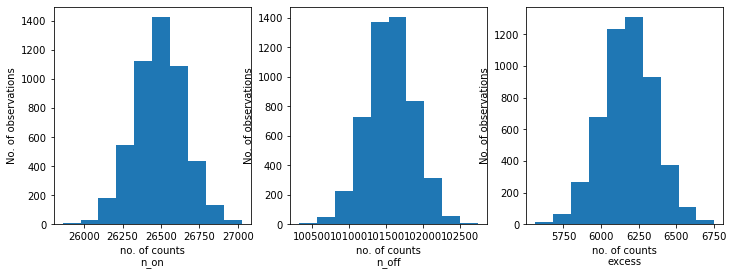

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

/home/rishank/anaconda2/envs/gammapy-0.12/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


CPU times: user 41min 2s, sys: 11.9 s, total: 41min 13s
Wall time: 46min 31s


In [15]:
results

[{'index': 2.169752569491976,
  'amplitude': 1.5653134721691003e-12,
  'lambda_': 5.7304570878812315},
 {'index': 2.393488523746745,
  'amplitude': 7.286175300846211e-13,
  'lambda_': 3.905504304079907},
 {'index': 2.05674633444537,
  'amplitude': 2.13609661023113e-12,
  'lambda_': 5.906316554578479},
 {'index': 2.2198891624283323,
  'amplitude': 1.2639851286831836e-12,
  'lambda_': 4.8690788872207404},
 {'index': 2.0251566902172473,
  'amplitude': 2.9214173989377874e-12,
  'lambda_': 7.501668200451735},
 {'index': 2.1591183874381765,
  'amplitude': 1.5123358711152705e-12,
  'lambda_': 5.317593059653128},
 {'index': 2.27786551050091,
  'amplitude': 1.18748129290514e-12,
  'lambda_': 5.30901410394558},
 {'index': 1.957657038806865,
  'amplitude': 2.9654928839917636e-12,
  'lambda_': 6.744542519944392},
 {'index': 2.367028293033707,
  'amplitude': 7.803183909775817e-13,
  'lambda_': 3.9453878125603405},
 {'index': 2.3072870942101904,
  'amplitude': 9.87768208600471e-13,
  'lambda_': 4.52

index: 2.20755502259602 += 0.13871645154321216


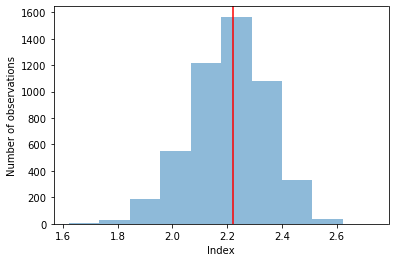

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.4821628426450447e-12 += 7.287990024045694e-13


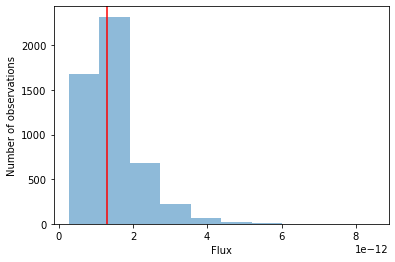

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 5.102855607263574 += 0.9798227666401869


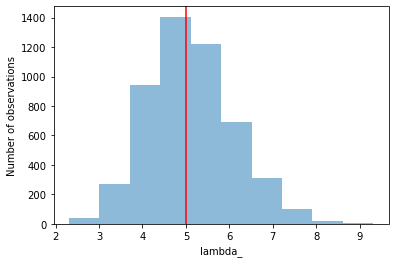

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")